<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>ASE: Total Variation Denoising</h2>
Semester 2, 2023<br>
</center>

In [150]:
import torch
from torch import optim
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Total Variation Denoising
Total variation denoising is an effective technique for eliminating noise from a signal while maintaining its distinct features intact. The algorithm employed in total variation denoising facilitates the enhancement of signal smoothness and continuity. More precisely, this method revolves around the resolution of the subsequent optimization problem:
$$
\begin{aligned}

\text{minimize}_{u}  \quad f_{\lambda}(u,x)= \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i |

\end{aligned}
$$

Firstly, we will show a simple example of total variation denoising of a one dimensional signal by using stochastic gradient descent to minimize the objective function $f_{\lambda}(u,x)$ with $\lambda=2$

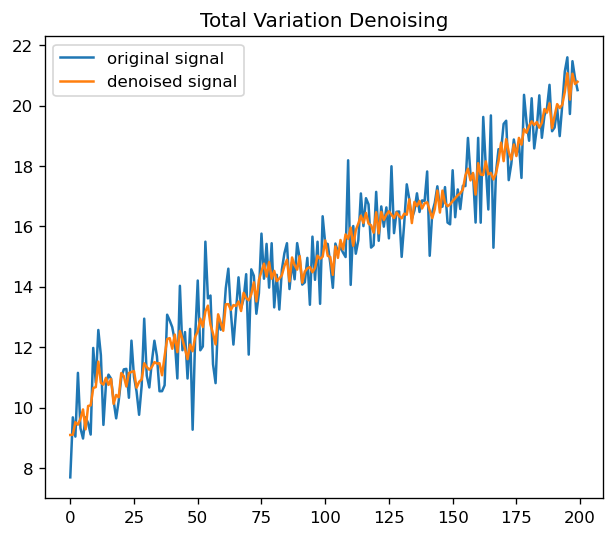

In [251]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd * torch.sum(torch.abs(u[1:]-u[:-1]))

# Simply implement 
torch.manual_seed(0)
signal = torch.linspace(10, 20, 200) + torch.randn(200, dtype=torch.double)
lmd = 2
u = torch.nn.Parameter(signal.clone())
optimizer = optim.SGD([u], lr=0.1)
for _ in range(400):
    optimizer.zero_grad()
    loss = f(u, signal, lmd)
    loss.backward()
    optimizer.step()

plt.figure(figsize=(6,5), dpi=120)
plt.plot(signal.detach(), label="original signal")
plt.plot(u.detach(),      label="denoised signal")
plt.legend()
plt.title("Total Variation Denoising")
plt.show()

## Automatic Differentiation in Declarative Node
We can define a `TotalVariationFcn` class for automatic differentiation for a declarative node. Suppose $x$ is the input to the declarative node and $y(x)$ is the output of the node. We can define the following function:
$$f_{\lambda}(u,x)= \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i |$$
$$y(x)  = \min_u f(u,x)$$

<p align="center">
  <img src="src/decNode.png" width="1000">
</p>


By math derivation, we can get the following nice derivative:
$$\frac{\mathrm{d}y}{\mathrm{d}x} = \mathbf{I}$$
where $\mathbf{I}$ is the identity matrix.

In [204]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd*torch.sum(torch.abs(u[1:]-u[:-1]))

def gradient(u):
   v = np.roll(u,1); v[0]=u[0]
   w = np.roll(u,-1); w[-1]=u[-1]
   return u-signal+lmd*(np.sign(u-v)-np.sign(w-u))

In [241]:
class TotalVariationFcn(torch.autograd.Function):
    """PyTorch autograd function for total variation denoising."""

    @staticmethod
    def forward(ctx, x, lmd):
        with torch.no_grad():
            u = torch.nn.Parameter(x.clone(), requires_grad=True)
            optimiser = optim.SGD([u], lr=0.08)
            for _ in range(200):
                optimiser.zero_grad()
                loss = f(u, x, lmd)
                loss.requires_grad = True
                loss.backward()
                optimiser.step()
            y = u.detach()
        return y

    @staticmethod
    def backward(ctx, dLdY):
        if dLdY is None:
            return None, None
        dLdX = dLdY
        return dLdX, None

Check the gradient of the `TotalVariationFcn` class by using `gradcheck` function in PyTorch:

In [244]:
# device = torch.device("cuda")
device = torch.device("cpu")

B, M = 2, 10
fcn = TotalVariationFcn.apply

torch.manual_seed(4399)
X = torch.randn((B, M), dtype=torch.double, device=device, requires_grad=True)

test = gradcheck(fcn, (X, 0.2), eps=1e-6, atol=1e-3, rtol=1e-6)
print("Backward test of DiffPolyFitFcn: {}".format(test))

Backward test of DiffPolyFitFcn: True


## Bi-Level Optimization, Profiling 
To profile the code, set up the following bi-level optimisation problem where the lower level problem is the total variation denoising problem:
$$
\begin{aligned}
\textbf{minimize}     & \quad  \frac{1}{2} \|y^\star-y^{\text{target}}\|_2^2 \\
\textbf{subject to}   & \quad  y^\star = \mathrm{argmin}_u \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i|
\end{aligned}
$$

In [ ]:
torch.manual_seed(8650)
M, N = 10, 4

# create a random data set with linear target signal
y_target = torch.linspace(10, 20, 200)
x = torch.rand()

In [260]:
def lower_level_fcn(x, lmd=0.2):
    u = torch.nn.Parameter(x.clone(), requires_grad=True)
    optimiser = optim.SGD([u], lr=0.08)
    for _ in range(200):
        optimiser.zero_grad()
        loss = f(u, x, lmd)
        #loss.requires_grad = True
        loss.backward()
        optimiser.step()
    y = u.detach()
    return y

def upper_level_fcn(y, y_target):
    return 0.5 * torch.sum((y-y_target)**2)

def composite_fcn(x, y_target, lmd=0.2):
    u = torch.nn.Parameter(x.clone(), requires_grad=True)
    optimiser = optim.SGD([u], lr=0.08)
    for _ in range(200):
        optimiser.zero_grad()
        loss = f(u, x, lmd)
        #loss.requires_grad = True
        loss.backward()
        optimiser.step()
    y = u.detach()
    return 0.5 * torch.sum((y-y_target)**2)

def implicit_grad_method(y_target, max_iter=200, lmd=0.2, lr=0.08):
    x = torch.nn.Parameter(torch.randn(len(y_target), dtype=torch.double), requires_grad=True)
    optimiser = optim.SGD([x], lr=lr)
    for _ in range(max_iter):
        optimiser.zero_grad()
        loss = composite_fcn(x, y_target)
        loss.requires_grad = True
        loss.backward()
        optimiser.step()
    return x.detach()

def auto_grad_method(y_target, max_iter=200, lmd=0.2, lr=0.08):
    fcn = TotalVariationFcn.apply
    x = torch.nn.Parameter(torch.randn(len(y_target), dtype=torch.double), requires_grad=True)
    optimiser = optim.SGD([x], lr=lr)
    for _ in range(max_iter):
        optimiser.zero_grad()
        loss = upper_level_fcn(fcn(x, lmd), y_target)
        loss.backward()
        optimiser.step()
    return x.detach()

In [265]:
import time
implicit_grad_method_time = []
auto_grad_method_time = []

max_dimension = 100

for i in range(max_dimension):
    y_target = torch.linspace(10, 90*(i+0.5), i); y_target.requires_grad = False
    
    start_time = time.time()
    x = implicit_grad_method(y_target)
    end_time = time.time()
    runtime = end_time - start_time
    implicit_grad_method_time.append(runtime)
    #print("Implicit Gradient Method Time: {}".format(runtime))

    start_time = time.time()
    x = auto_grad_method(y_target)
    end_time = time.time()
    runtime = end_time - start_time
    auto_grad_method_time.append(runtime)
    #print("Auto Gradient Method Time: {}".format(runtime))
    
    print(('\rProcess：{}/'+str(max_dimension)).format(i), end='')

Process：99/100

ValueError: 
y_{\text{target}}
   ^
ParseSyntaxException: Unknown symbol: \text, found '\'  (at char 3), (line:1, col:4)

<Figure size 720x600 with 1 Axes>

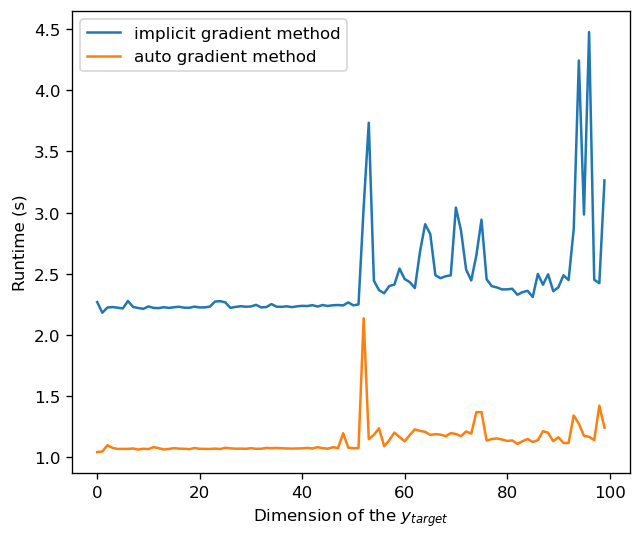

In [266]:
plt.figure(figsize=(6,5), dpi=120)
plt.plot(implicit_grad_method_time, label="implicit gradient method")
plt.plot(auto_grad_method_time,      label="auto gradient method")
plt.legend()
plt.xlabel("Dimension of the $y_{target}$")
plt.ylabel("Runtime (s)")
plt.show()